In [2]:
import os
import pandas as pd

os.chdir('../../db/factor')
os.getcwd()

'/Users/test/risksoft/TS/db/factor'

In [4]:
arma = pd.read_parquet("Factor_ARMA_20200327_20240621.parquet")
garch = pd.read_parquet("Factor_Garch_20200327_20240621.parquet")
arma.head(1)

標的碼,9910,2454,2412,2408,2395,2382,2357,2330,2327,2317,...,2603,2615,2609,8454,3037,6770,1605,2345,3231,3661
da1,,,,,,,,,,,,,,,,,,,,,
2020-03-27,0.013507,0.044973,-0.000344,0.008841,0.025479,0.004536,0.001169,0.014215,0.011979,-0.000244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
garch.tail(1)

標的碼,9910,2454,2412,2408,2395,2382,2357,2330,2327,2317,...,2603,2615,2609,8454,3037,6770,1605,2345,3231,3661
da1,,,,,,,,,,,,,,,,,,,,,
2024-06-21,0.0,0.003385,0.000087,0.002241,0.000647,0.003108,0.0017,0.001639,0.00125,0.002943,...,0.003364,0.0,0.0,0.0,0.001798,0.0,0.0,0.002835,0.001628,0.004944


In [7]:
pct_close = pd.read_parquet("../../db/tw/pdata/cl_pct.parquet")
pct_close = pct_close.pct_change().dropna(how='all')
pct_close.index = pd.to_datetime(pct_close.index)
pct_close_w = pct_close.resample("W-FRI").sum()

In [54]:
factor = arma

In [55]:
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    long_only_weighting = weighting[weighting > 0].fillna(0.0)*2
    return long_only_weighting

quantile = 6
time_length = len(factor)
quantile_column = [[None]*quantile]*time_length
quantile_df = pd.DataFrame(quantile_column)
for da in range(time_length):
    row = factor.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i:i+int(len(row)/quantile)])

pct_close_w_corres = pct_close_w[pct_close_w.columns.intersection(factor.columns)].shift(-1)

index = factor.index
quantiles = [None] * quantile
for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    df_1 = factor.copy()
    for i in range(len(quantile_1)):
        df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
        
        
        # factor quantilize => weighting => * pct
    weighting = get_demean_weighting(df_1)
    
    ret = pct_close_w_corres.loc[weighting.index[0]:] * weighting
    quantiles[qt_iter] = (1+ret.sum(axis=1)).cumprod() -1

<Axes: xlabel='da1'>

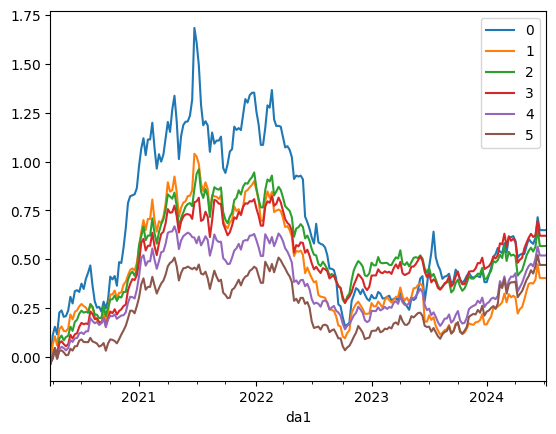

In [56]:
quantilized_cumsum = pd.DataFrame(quantiles).T
quantilized_cumsum.plot()

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='da1'>

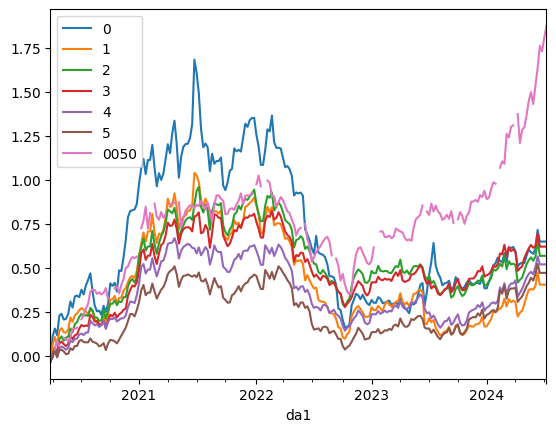

In [57]:
import yfinance as yf
z = yf.download("0050.TW", start=quantilized_cumsum.index[0])[['Adj Close']]
quantilized_cumsum['0050'] = ((1+z.pct_change()).cumprod()-1)
quantilized_cumsum.plot()


In [61]:
factor.apply(lambda x: print(x), axis=1)

標的碼
9910    0.013507
2454    0.044973
2412   -0.000344
2408    0.008841
2395    0.025479
          ...   
6770         NaN
1605         NaN
2345         NaN
3231         NaN
3661         NaN
Name: 2020-03-27 00:00:00, Length: 67, dtype: float64
標的碼
9910   -0.008223
2454   -0.009569
2412    0.000624
2408    0.017462
2395    0.002812
          ...   
6770         NaN
1605         NaN
2345         NaN
3231         NaN
3661         NaN
Name: 2020-04-03 00:00:00, Length: 67, dtype: float64
標的碼
9910   -0.014073
2454   -0.002202
2412   -0.000271
2408   -0.027075
2395   -0.002804
          ...   
6770         NaN
1605         NaN
2345         NaN
3231         NaN
3661         NaN
Name: 2020-04-10 00:00:00, Length: 67, dtype: float64
標的碼
9910   -0.006459
2454   -0.013948
2412   -0.000067
2408    0.029694
2395   -0.024547
          ...   
6770         NaN
1605         NaN
2345         NaN
3231         NaN
3661         NaN
Name: 2020-04-17 00:00:00, Length: 67, dtype: float64
標的碼
9910   -0.007526

da1
2020-03-27    None
2020-04-03    None
2020-04-10    None
2020-04-17    None
2020-04-24    None
              ... 
2024-05-24    None
2024-05-31    None
2024-06-07    None
2024-06-14    None
2024-06-21    None
Length: 222, dtype: object

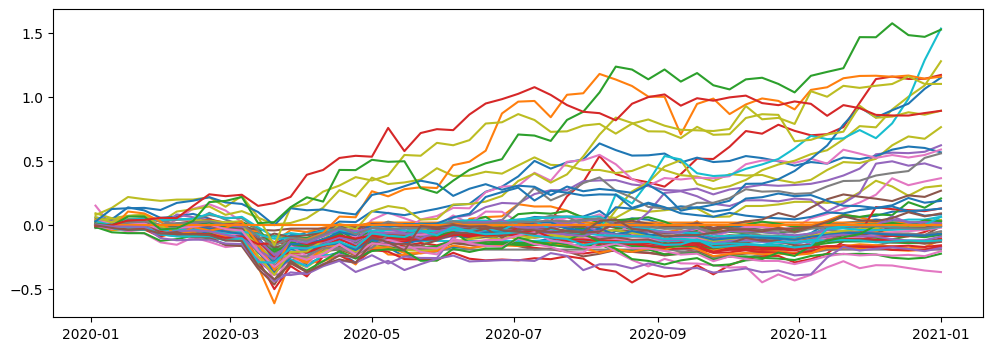

In [47]:
all = pct_close_w[pct_close_w.columns.intersection(factor.columns)].loc['2020-01-01':'2021-01-01']
all_cumsum = all.cumsum()
plt.figure(figsize=(12,4))
plt.plot(all_cumsum)
plt.show()